#### Import libraries

In [1]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
from nltk.stem import PorterStemmer
import pandas as pd
import string
import re
from sklearn.feature_extraction.text import CountVectorizer
import timeit
import time
import matplotlib.pyplot as plt


#### Get data

In [3]:
def get_and_clean_data():
    data = pd.read_csv('../Resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' ' * len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description

#### Experiment

In [2]:

def setup_exp( samples):
        cleaned_description = get_and_clean_data()[:samples]

        # replace non-alphabets with spaces, and collapse spaces
        cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
        cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+', ' ', s))

        # tokenize
        tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

        # remove stop words
        stop_dict = set(stopwords.words())
        sw_removed_description = tokenized_description.apply(lambda s: set(s) - stop_dict)
       
        sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word) > 2])

        # create stem caches
        concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
        stem_cache = {}
        ps = PorterStemmer()
        for s in concated:
            stem_cache[s] = ps.stem(s)

        # stem
        stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])

        # print(tokenized_description)
        cv = CountVectorizer(analyzer=lambda x: x)
        vectorizer = cv.fit(stemmed_description)
        X = vectorizer.transform(stemmed_description)
        return X


#### Performance test

In [4]:
initial_w = 10000
num_iterations = int(np.log2(initial_w)) + 1

arr = {}
dok = {}
lil = {}
coo = {}
csc = {}

# Loop over the values of w
for i in range(num_iterations):
    w = initial_w // (2 ** i)
    print("Iteration {}: w = {}".format(i + 1, w))
    
    X = setup_exp(w)
    
    arr[w] = timeit.timeit(lambda: np.matmul(X.toarray(), X.toarray().T), number=1)
    dok[w] = timeit.timeit(lambda: X.todok() * X.T.todok(), number=1)
    lil[w] = timeit.timeit(lambda: X.tolil() * X.T.tolil(), number=1)
    coo[w] = timeit.timeit(lambda: X.tocoo() * X.T.tocoo(), number=1)
    csc[w] = timeit.timeit(lambda: X.tocsc() * X.T.tocsc(), number=1)

# Print the results
print("Array Multiplication:", arr)
print("Dok Multiplication:", dok)
print("Lil Multiplication:", lil)
print("Coo Multiplication:", coo)
print("Csc Multiplication:", csc)

Iteration 1: w = 10000
Iteration 2: w = 5000
Iteration 3: w = 2500
Iteration 4: w = 1250
Iteration 5: w = 625
Iteration 6: w = 312
Iteration 7: w = 156
Iteration 8: w = 78
Iteration 9: w = 39
Iteration 10: w = 19
Iteration 11: w = 9
Iteration 12: w = 4
Iteration 13: w = 2
Iteration 14: w = 1
Array Multiplication: {10000: 1713.5145113289982, 5000: 553.072196795998, 2500: 94.71862015199804, 1250: 16.23425383400172, 625: 2.693023539999558, 312: 0.4390466610020667, 156: 0.05948344900025404, 78: 0.00985719099844573, 39: 0.002058859001408564, 19: 0.0003593910005292855, 9: 6.346600275719538e-05, 4: 3.9881000702735037e-05, 2: 2.7583999326452613e-05, 1: 2.8911999834235758e-05}
Dok Multiplication: {10000: 7.991445867999573, 5000: 3.5088719410014164, 2500: 1.1049842719985463, 1250: 0.4119584330001089, 625: 0.17449165300058667, 312: 0.07869059199947515, 156: 0.028021258000080707, 78: 0.012684974000876537, 39: 0.005886725997697795, 19: 0.003315428002679255, 9: 0.0020834720016864594, 4: 0.0013052550

#### Linear graph

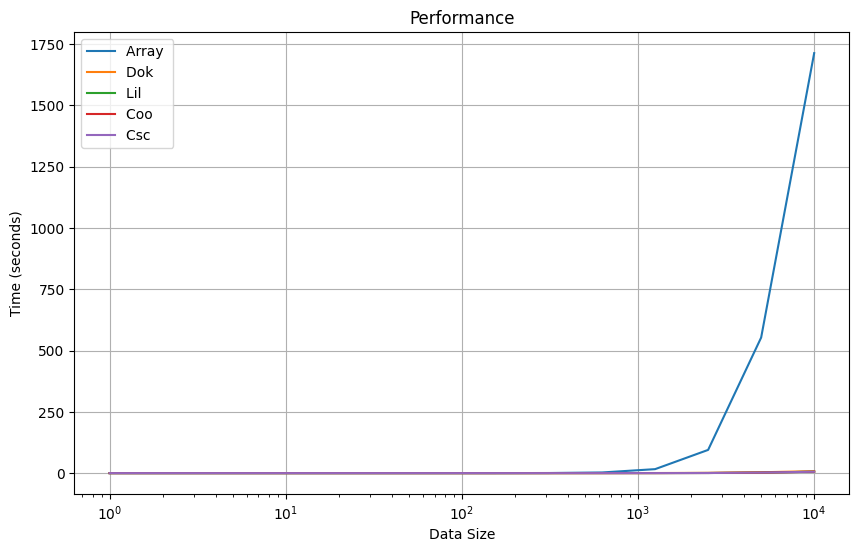

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))

plt.plot(list(arr.keys()), list(arr.values()), label='Array ')
plt.plot(list(dok.keys()), list(dok.values()), label='Dok ')
plt.plot(list(lil.keys()), list(lil.values()), label='Lil ')
plt.plot(list(coo.keys()), list(coo.values()), label='Coo ')
plt.plot(list(csc.keys()), list(csc.values()), label='Csc ')

plt.xscale('log') 

plt.title('Performance')
plt.xlabel('Data Size')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)
plt.show()